<a href="https://colab.research.google.com/github/sepidehrezvani/10-/blob/main/Crc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

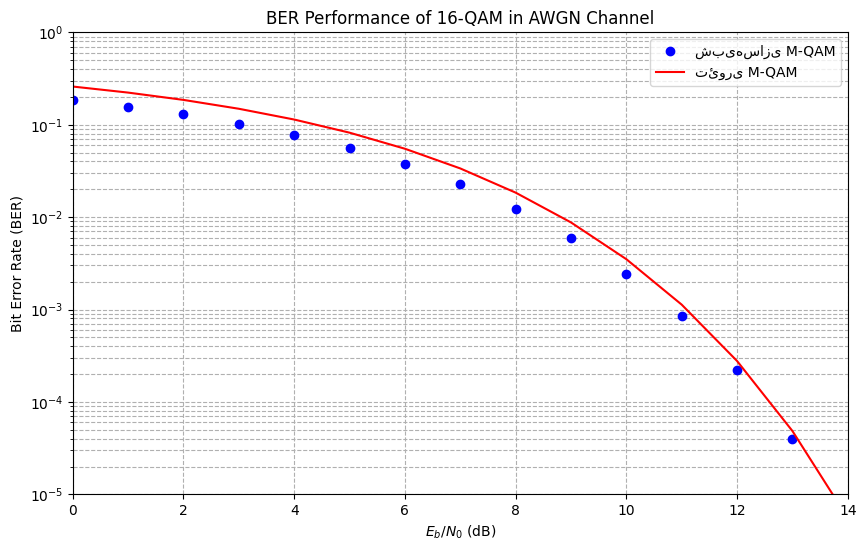

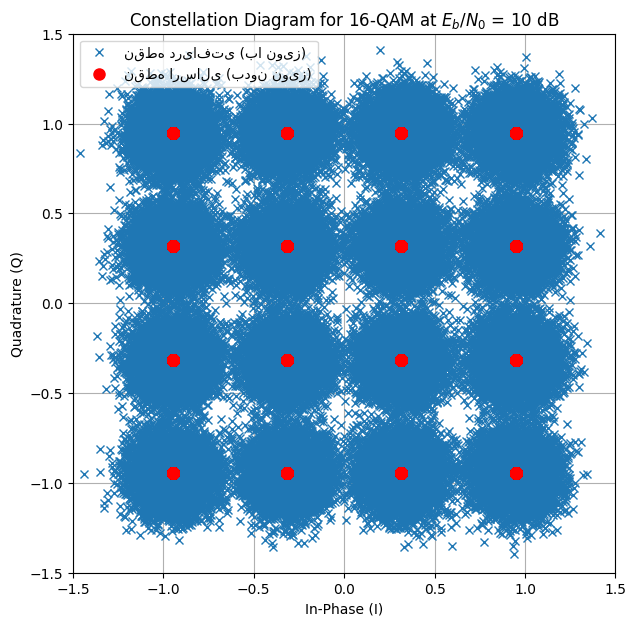

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

# --- تنظیمات پارامترهای QAM ---
M = 16 # مرتبه مدولاسیون (برای Higher-Order QAM) - باید توانی از 2 باشد (مثلاً 16، 64، 256)
k = np.log2(M) # تعداد بیت در هر سمبل
if k != int(k):
    raise ValueError("M باید توانی از 2 باشد (مثلاً 4، 16، 64، ...)")
k = int(k)

# --- تنظیمات شبیه سازی ---
N_symbols = 10**5 # تعداد سمبل‌های شبیه‌سازی
Eb_N0_dB_range = np.arange(0, 15, 1) # محدوده Eb/N0 بر حسب دسی‌بل

# --- توابع مدولاسیون و دمدولاسیون ---

def qam_modulation(bits, M):
    # نگاشت Gray-coding برای M-QAM مربعی
    k = int(np.log2(M))
    s = int(np.sqrt(M))

    # تبدیل بیت‌ها به اعداد صحیح سمبل
    bits_reshaped = bits.reshape(-1, k)
    int_symbols = np.sum(bits_reshaped * (2**np.arange(k-1, -1, -1)), axis=1)

    # تعیین مختصات I و Q از روی اعداد صحیح (با فرض Gray-code)
    # برای QAM مربعی، مختصات I و Q از {-(s-1), -(s-3), ..., (s-3), (s-1)} گرفته می‌شوند.
    amplitude_levels = np.arange(-(s-1), s, 2)

    # ساخت نگاشت Gray-code به صورت دستی یا استفاده از توابع مخصوص
    # برای سادگی، فعلاً از نگاشت ترتیبی استفاده می‌کنیم که برای مقایسه با تئوری کافی است
    # برای پیاده سازی دقیق Gray-coding، به جدول نگاشت نیاز است.

    # نگاشت ساده ترتیبی به مختصات I/Q (برای M مربعی)
    # سطح I و Q در یکدیگر ضرب می‌شوند تا به سمبل نهایی برسیم.
    # اندیس‌های I و Q
    i_indices = int_symbols % s
    q_indices = int_symbols // s

    # نگاشت به مختصات I و Q حقیقی
    I_components = amplitude_levels[i_indices]
    Q_components = amplitude_levels[q_indices]

    # سمبل‌های مختلط
    symbols = I_components + 1j * Q_components

    # نرمال‌سازی توان متوسط به 1
    E_avg = np.mean(np.abs(symbols)**2)
    normalized_symbols = symbols / np.sqrt(E_avg)

    return normalized_symbols, E_avg

def qam_demodulation(received_symbols, M, E_avg):
    k = int(np.log2(M))
    s = int(np.sqrt(M))

    # حذف نرمال‌سازی
    normalized_received = received_symbols * np.sqrt(E_avg)

    # تعیین سطوح آستانه
    threshold_levels = np.arange(-(s-1)+1, s-1, 2)
    amplitude_levels = np.arange(-(s-1), s, 2)

    # دمدولاسیون مولفه I (بخش حقیقی)
    I_received = np.real(normalized_received)
    I_indices = np.digitize(I_received, threshold_levels)

    # دمدولاسیون مولفه Q (بخش موهومی)
    Q_received = np.imag(normalized_received)
    Q_indices = np.digitize(Q_received, threshold_levels)

    # تبدیل به اندیس سمبل
    demod_symbols_indices = Q_indices * s + I_indices

    # تبدیل اندیس سمبل به بیت (معکوس کردن نگاشت ترتیبی)
    demod_bits = np.zeros(len(demod_symbols_indices) * k, dtype=int)
    for i, symbol_index in enumerate(demod_symbols_indices):
        bits_local = np.zeros(k, dtype=int)

        # تبدیل عدد صحیح به باینری
        temp = symbol_index
        for j in range(k):
            bits_local[k - 1 - j] = temp % 2
            temp //= 2

        demod_bits[i*k:(i+1)*k] = bits_local

    return demod_bits

# --- محاسبه BER تئوری (AWGN) ---
def ber_mqam_theory(Eb_N0_dB, M):
    k = np.log2(M)
    Eb_N0 = 10**(Eb_N0_dB / 10)
    gamma_s = k * Eb_N0

    # برای QAM مربعی (Gray-coding فرض شده است)
    P_e = (1 - 1/np.sqrt(M)) * sp.erfc(np.sqrt((3 * gamma_s) / (2 * (M - 1))))
    P_b = (4 / k) * P_e - (4 / (k * np.sqrt(M))) * P_e**2
    return P_b

# --- شبیه‌سازی اصلی ---
sim_ber = []
for Eb_N0_dB in Eb_N0_dB_range:
    # تولید بیت‌های تصادفی
    bits = np.random.randint(0, 2, int(N_symbols * k))

    # ۱. مدولاسیون
    tx_symbols, E_avg = qam_modulation(bits, M)

    # ۲. کانال AWGN

    # Eb/N0 به نسبت توان سیگنال به توان نویز تبدیل می‌شود (Es/N0)
    Es_N0_linear = k * 10**(Eb_N0_dB / 10)

    # N0 (توان نویز)
    # از آنجایی که E_avg برابر 1 است، توان سیگنال هم 1 است (Ps=1).
    # N0 = Es / (Es/N0) = 1 / Es_N0_linear (توان نویز تک‌طرفه)

    # برای نویز گاوسی مختلط (variance نویز در I و Q)
    # N0/2 در هر مولفه (I و Q)
    sigma_n = 1 / np.sqrt(2 * Es_N0_linear)

    # تولید نویز گاوسی مختلط
    noise = sigma_n * (np.random.normal(0, 1, len(tx_symbols)) + 1j * np.random.normal(0, 1, len(tx_symbols)))

    # سیگنال دریافتی
    rx_symbols = tx_symbols + noise

    # ۳. دمدولاسیون
    demod_bits = qam_demodulation(rx_symbols, M, E_avg)

    # ۴. محاسبه نرخ خطای بیت (BER)
    n_errors = np.sum(bits != demod_bits)
    ber = n_errors / len(bits)
    sim_ber.append(ber)

# --- محاسبه BER تئوری ---
theory_ber = ber_mqam_theory(Eb_N0_dB_range, M)

# --- رسم نمودار ---
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_N0_dB_range, sim_ber, 'bo', label='شبیه‌سازی M-QAM')
plt.semilogy(Eb_N0_dB_range, theory_ber, 'r-', label='تئوری M-QAM')
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title(f'BER Performance of {M}-QAM in AWGN Channel')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.xlim([Eb_N0_dB_range[0], Eb_N0_dB_range[-1]])
plt.ylim([1e-5, 1])
plt.show()

# --- نمایش Constellation Diagram (نمودار صورت فلکی) برای یک Eb/N0 خاص ---
Eb_N0_constellation = 10 # dB
Es_N0_linear_constellation = k * 10**(Eb_N0_constellation / 10)
sigma_n_constellation = 1 / np.sqrt(2 * Es_N0_linear_constellation)
noise_constellation = sigma_n_constellation * (np.random.normal(0, 1, len(tx_symbols)) + 1j * np.random.normal(0, 1, len(tx_symbols)))
rx_symbols_constellation = tx_symbols + noise_constellation

plt.figure(figsize=(7, 7))
plt.plot(np.real(rx_symbols_constellation), np.imag(rx_symbols_constellation), 'x', label='نقطه دریافتی (با نویز)')
plt.plot(np.real(tx_symbols), np.imag(tx_symbols), 'ro', label='نقطه ارسالی (بدون نویز)', markerfacecolor='r', markersize=8)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title(f'Constellation Diagram for {M}-QAM at $E_b/N_0$ = {Eb_N0_constellation} dB')
plt.grid(True)
plt.legend()
plt.show()